### Autores:  
Blanco García, Gabriel: gabriel.blanco@cunef.edu  
Ferrín Meilán, Michelle: michelle.ferrin@cunef.edu

## Colegio Universitario de Estudios Financieros
### Máster en Data Science para Finanzas
Madrid, diciembre de 2020

# Optimización de hiperparámetros: XGBoost

Los hiperparámetros de un modelo son aquellos parámetros que controlan aspectos relativos a la manera en que se entrena el modelo, como por ejemplo el número de estimadores, la función de coste que se utiliza para calcular el error, etc. La optimización de hiperparámetros consiste en probar distitnas combinaciones de hiperparámetros sobre un mismo modelo, y comparar los resultados con el fin de elegir una configuración que mejore los resultados originales.

El procedimiento es el siguiente: se construye una tabla o "grid" que contenga todos los parámetros que queremos probar y se ejecuta el modelo probando distintas combinaciones. Hay dos enfoques principales, la búsqueda grid y la búsqueda aleatoria.  

En la búsqueda grid, dependiento del número de iteraciones que se utilicen, se exploran __muchas__ combinaciones de hiperparámetros, algo que aumenta la precisión de los resultados pero dispara el coste computacional.  

Por el contrario, en la búsqueda aleatoria, se elige un número de combinaciones al azar, y se prueban. No se explorar todas las posibilidades, lo que reduce la calidad de los resultados, pero acorta el tiempo de ejecución.  

De igual manera que existe el trade-off entre sesgo y varianza en los modelos, en Machine Learning también existe el trade-off entre calidad de los resultados y coste computacional asociado. En este trabajo implementamos la segunda opción, la búsqueda aleatoria. Existen otras formas más avanzadas de optimizar hiperparámetros, como la bayesiana, pero que hemos descartado por no extender demasiado el proceso 

Llevamos a cabo distintas optimizaciones, de menor a mayor carga. Para ello, utilizamos el 20% de los datos que hemos reservado como conjunto de validación

In [1]:
# Manipulacion
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import scikitplot as skplt

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# El modelo
from sklearn.ensemble import GradientBoostingClassifier 

# La búsqueda aleatoria con validación cruzada
from sklearn.model_selection import  RandomizedSearchCV  

# Evaluación de modelo
from sklearn import metrics 

# Guardar el modelo
import pickle 

# Métricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Guardar y cargar modelos, cargar pipelines 
%run ../src/operar_modelos.ipynb
%run ../src/lectura_y_preprocesado.ipynb
%run ../src/plots_metricas.ipynb

# Ocultar warnings
import warnings
warnings.filterwarnings('ignore')

Cargamos los datos de validación y test

In [3]:
X_validation = pd.read_csv('../data/validation/X_validation.csv', engine='python')
y_validation = pd.read_csv('../data/validation/y_validation.csv', engine='python')

In [4]:
X_test = pd.read_csv('../data/test/X_test.csv', engine='python')
y_test = pd.read_csv('../data/test/y_test.csv', engine='python')

Cargamos el modelo ganador, el XGBoost

In [5]:
XGBoost = cargar_modelo('../models/trained_models/XGBoost.sav')

Llevamos a cabo varias optimizaciones. La primera optimización es bastante simple, validación cruzada con 3 folds, 4 posibles modelos, en total 12 ajustes

### Primera optimización

Definimos los hiperparámetros: distintos números de estimadores, y distintos critérios de cálculo del número de variales consideradas para la división de cada rama

In [6]:
hiperparametros = {
    'clasificador__max_features': ['auto', 'sqrt', 'log2'],
    'clasificador__n_estimators': [250, 500]}

Construimos el primer objeto de optimización

In [11]:
Optimized_XGBoost = RandomizedSearchCV(XGBoost, # el modelo cargado, sin parámetros 
                                       hiperparametros, # los hiperparámetros definidos arriba
                                       cv=3,  # solo 3 folds
                                       n_iter=4, # 4 combinaciones
                                       verbose=1, # para que vaya informando del proceso 
                                       random_state=1234, # asegura la reproductibilidad 
                                       n_jobs=3) # 3 nucleos trabajando

El argumento `verbose` proporciona información útil acerca del proceso. Cuanto mayor sea su número, más mensajes dará.

Lanzamos el modelo sobre los datos de validación

In [12]:
Optimized_XGBoost.fit(X_validation, y_validation)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesador',
                                              ColumnTransformer(transformers=[('numericas',
                                                                               Pipeline(steps=[('imputador',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('escalador',
                                                                                                StandardScaler())]),
                                                                               Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'annual_inc_joint',
       'dti_joint', 'mort_acc'],
      dtype='object')),
                                                                              ('categoricas',
                                                   

In [16]:
Optimized_XGBoost.best_score_

0.78607283474927

Podemos obetner los parámetros del mejor modelo

In [17]:
Optimized_XGBoost.best_params_

{'clasificador__n_estimators': 500, 'clasificador__max_features': 'log2'}

Y el accuracy

In [21]:
Optimized_XGBoost.best_estimator_.score(X_test, y_test)

0.7878276485033373

La precisión del XGBoost sin optimizar los hiperparámetros era de 78.8%. Guardamos este modelo y probamos optimizaciones más largas.

In [26]:
guardar_modelo(Optimized_XGBoost.best_estimator_, '../models/trained_models/Optimized_XGBoost.sav')

### Segunda optimización

Añadimos la posibilidad de utilizar distintas funciones de pérdida

In [27]:
hiperparametros = {
    'clasificador__loss': ['deviance', 'exponential'],
    'clasificador__max_features': ['auto', 'sqrt', 'log2'],
    'clasificador__n_estimators': [250, 500, 750]}

In [29]:
Optimized_XGBoost_V2 = RandomizedSearchCV(XGBoost, # el modelo cargado, sin parámetros 
                                       hiperparametros, # los hiperparámetros definidos arriba
                                       cv=3,  # solo 3 folds
                                       n_iter=5, # 5 combinaciones
                                       verbose=1, # para que vaya informando del proceso 
                                       random_state=1234, # asegura la reproductibilidad 
                                       n_jobs=3) # 3 nucleos trabajando

In [30]:
Optimized_XGBoost_V2.fit(X_validation, y_validation)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  7.6min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesador',
                                              ColumnTransformer(transformers=[('numericas',
                                                                               Pipeline(steps=[('imputador',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('escalador',
                                                                                                StandardScaler())]),
                                                                               Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'annual_inc_joint',
       'dti_joint', 'mort_acc'],
      dtype='object')),
                                                                              ('categoricas',
                                                   

In [32]:
Optimized_XGBoost_V2.best_estimator_.score(X_test, y_test) # 78.79%, ligeramente mejor

0.7878925561721785

La precisión es algo mejor que en la primera optimización, pero sigue siendo menor que el XGBoost base

In [33]:
Optimized_XGBoost_V2.best_params_ # Estos son los parámetros del mejor modelo del segundo intento

{'clasificador__n_estimators': 750,
 'clasificador__max_features': 'log2',
 'clasificador__loss': 'exponential'}

Guardamos el modelo y probamos con más parámetros

In [34]:
guardar_modelo(Optimized_XGBoost_V2.best_estimator_, '../models/trained_models/Optimized_XGBoost_V2.sav')

### Tercera optimización

Es similar a la anterior, pero añadimos la posibilidad de que usen más estimadores, 1000 y 1500. 

In [5]:
hiperparametros = {
    'clasificador__loss': ['deviance', 'exponential'],
    'clasificador__max_features': ['auto', 'sqrt', 'log2'],
    'clasificador__n_estimators': [500, 750, 1000, 1500]}

In [6]:
Optimized_XGBoost_V3 = RandomizedSearchCV(XGBoost, # el modelo cargado, sin parámetros 
                                       hiperparametros, # los hiperparámetros definidos arriba
                                       cv=3,  # solo 3 folds
                                       n_iter=7, #  7 combinaciones
                                       verbose=1.5, # para que vaya informando del proceso 
                                       random_state=1234, # asegura la reproductibilidad 
                                       n_jobs=3) # 3 nucleos trabajando

In [7]:
Optimized_XGBoost_V3.fit(X_validation, y_validation)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed: 19.0min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesador',
                                              ColumnTransformer(transformers=[('numericas',
                                                                               Pipeline(steps=[('imputador',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('escalador',
                                                                                                StandardScaler())]),
                                                                               Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'annual_inc_joint',
       'dti_joint', 'mort_acc'],
      dtype='object')),
                                                                              ('categoricas',
                                                   

In [9]:
Optimized_XGBoost_V3.best_estimator_.score(X_test, y_test) # 78.77%, peor 

0.7877735587793031

Parámetros del mejor modelo

In [10]:
Optimized_XGBoost_V3.best_params_

{'clasificador__n_estimators': 500,
 'clasificador__max_features': 'sqrt',
 'clasificador__loss': 'exponential'}

Guardamos el modelo

In [11]:
guardar_modelo(Optimized_XGBoost_V3, '../models/trained_models/Optimized_XGBoost_V3.sav')

# Última optimización

Hacemos una última optimización, poniendo más profundidad a los árboles. No incluimos el deviance, porque el exponential es el que ha ganado en los otros intentos. Se excluye "auto" de los posibles hiperparámetros para calcular el número de variables por el mismo motivo.

In [93]:
hiperparametros = {
    'clasificador__loss': ['exponential'],
    'clasificador__max_features': ['sqrt', 'log2'],
    'clasificador__n_estimators': [500, 750, 1000],
    'clasificador__max_depth': [4, 5, 6, 7, 9]} 

In [95]:
Optimized_XGBoost_V5_CV_10 = RandomizedSearchCV(XGBoost, # el modelo cargado, sin parámetros 
                                       hiperparametros, # los hiperparámetros definidos arriba
                                       cv=10,  # 10 folds
                                       n_iter=10, #  10 combinaciones, es el valor por defecto, pero lo ponemos por enfatizar
                                       verbose=1.5, # para que vaya informando del proceso 
                                       random_state=1234, # asegura la reproductibilidad 
                                       n_jobs=3) # 3 nucleos trabajando

In [97]:
Optimized_XGBoost_V5_CV_10.fit(X_validation, y_validation)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 tasks      | elapsed: 23.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 72.1min finished


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocesador',
                                              ColumnTransformer(transformers=[('numericas',
                                                                               Pipeline(steps=[('imputador',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('escalador',
                                                                                                StandardScaler())]),
                                                                               Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'annual_inc_joint',
       'dti_joint', 'mort_acc'],
      dtype='object')),
                                                                              ('categoricas',
                                                  

In [98]:
Optimized_XGBoost_V5_CV_10.best_params_ # Sigue saliendo el mismo modelo que el V4

{'clasificador__n_estimators': 500,
 'clasificador__max_features': 'log2',
 'clasificador__max_depth': 4,
 'clasificador__loss': 'exponential'}

In [100]:
Optimized_XGBoost_V5_CV_10.best_estimator_.score(X_test, y_test)

0.7881954586267701

Guardamos el modelo

In [122]:
guardar_modelo(Optimized_XGBoost_V5_CV_10, '../models/trained_models/Best_XGBoost.sav')

### Resultado de la optimización 

Evaluamos el modelo optimizado y lo comparamos con el XGBoost sin optimizar. Cargamos ambos modelos, porque este notebook no se terminó en la misma sesión

In [6]:
XGBoost = cargar_modelo('../models/trained_models/XGBoost.sav')

In [8]:
Optimized_XGBoost = cargar_modelo('../models/trained_models/Best_XGBoost.sav') 

### XGBoost optimizado

Calculamos su accuracy, AUC y tasa de falsos positivos y la comparamos con el XGBoost normal

In [9]:
accuracy(Optimized_XGBoost)

0.7881954586267701

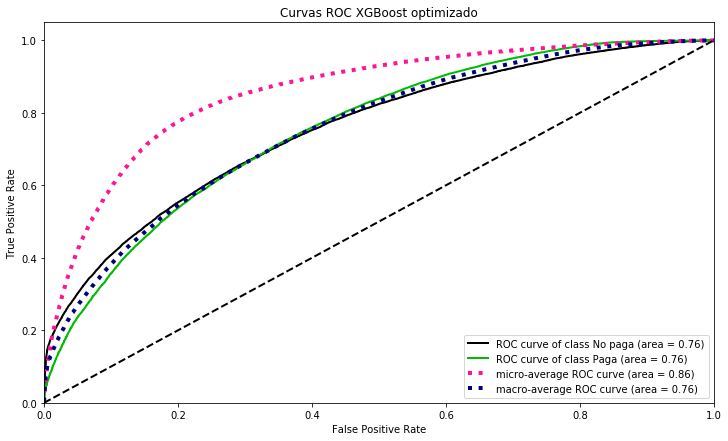

In [10]:
grafico_roc(Optimized_XGBoost, 'Curvas ROC XGBoost optimizado')

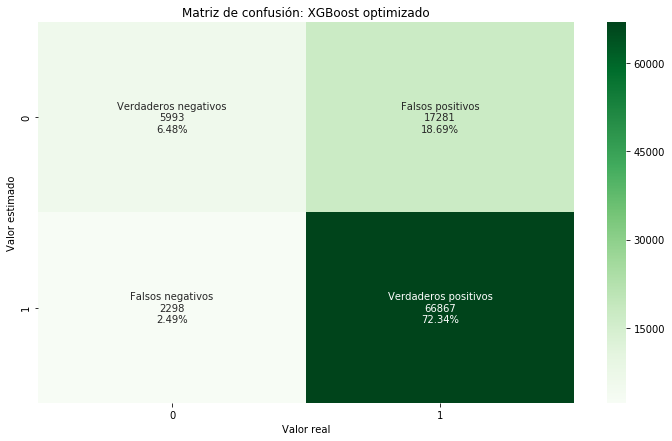

In [11]:
plot_matriz_confusion(Optimized_XGBoost, 'Matriz de confusión: XGBoost optimizado')

### Comparación con el XGBoost sin optimizar 

Construimos la tabla

In [12]:
datos_performance_modelos = {'Modelo': ['XGBoost base', 'XGBoost optimizado'],
                             
                             'Accuracy': ['78.8152%', '78.8195%'],
                             
                             'Área bajo la curva ROC': ['0.75', '0.76'],
                             
                             'Tasa de falsos positivos': ['18.82%', '18.69%']}

resumen_performance = pd.DataFrame(datos_performance_modelos, columns=['Modelo', 
                                                                       'Accuracy', 
                                                                       'Área bajo la curva ROC',
                                                                       'Tasa de falsos positivos'])

resumen_performance

,Modelo,Accuracy,Área bajo la curva ROC,Tasa de falsos positivos
0,XGBoost base,78.8152%,0.75,18.82%
1,XGBoost optimizado,78.8195%,0.76,18.69%


Tal como se puede observar, la mejora en accuracy no es sustancial, aunque el modelo optimizado es más preciso. El área bajo la curva ROC aumenta ligeramente, de 0.75 a 0.76. Lo más interesante es que este modelo consigue rebajar la tasa de falsos positivos en un 1.3%, de un total de 17.396 a 17.281, lo que supone un total de 115 créditos impagados bien clasificados, algo que se traduce en menos pérdida para la empresa. Las comparaciones son posibles porque las métricas de ambos modelos se calculan sobre el mismo conjunto, sobre el de test

Finalmente, en el siguiente notebook se examinan más a fondo los resultados del modelo optimizado y se valoran más métricas. Este es el modelo que se pondrá en prodcucción.